# Deception Detection in Diplomacy
## Solution By - PARADOX


# Intalling Libraries

In [1]:
!pip install -q sentence-transformers==2.2.2 lightgbm==3.3.2 imbalanced-learn==0.10.1 scikit-learn==1.2.2

# Importing Libraries

In [2]:
import os, random, math, time, re
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from collections import defaultdict
import joblib

# Defining Parameters

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input Files

In [4]:
TRAIN_CSV = "train.csv"
TEST_CSV  = "test.csv"
COMMS_CSV = "commentary.csv"
for f in [TRAIN_CSV, TEST_CSV, COMMS_CSV]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Upload {f} into Colab working directory")

train_msgs = pd.read_csv(TRAIN_CSV)
test_msgs  = pd.read_csv(TEST_CSV)
comms_all  = pd.read_csv(COMMS_CSV)

print("Loaded rows:", len(train_msgs), len(test_msgs), len(comms_all))


Loaded rows: 13132 2741 1787


# Preprocessing

In [5]:
# merge commentary
train = pd.merge(train_msgs, comms_all, left_on=["game_id","year","season","speaker"],
                 right_on=["game_id","year","season","player"], how="left", suffixes=("","_comm"))
test = pd.merge(test_msgs, comms_all, left_on=["game_id","year","season","speaker"],
                right_on=["game_id","year","season","player"], how="left", suffixes=("","_comm"))
if "commentary" not in train.columns and "commentary_comm" in train.columns:
    train["commentary"] = train["commentary_comm"].fillna("")
    test["commentary"]  = test["commentary_comm"].fillna("")
train["commentary"] = train["commentary"].fillna("").astype(str)
test["commentary"]  = test["commentary"].fillna("").astype(str)

# robust label parsing
def parse_label_safe(v, default=np.nan):
    if pd.isnull(v): return default
    if isinstance(v, (int, float, np.integer, np.floating)): return int(v)
    s = str(v).strip().lower()
    if s in ["true","1","t","yes","y"]: return 1
    if s in ["false","0","f","no","n"]: return 0
    return default

train = train.dropna(subset=["sender_label"]).copy()
train["sender_label"] = train["sender_label"].apply(parse_label_safe)
test["sender_label"]  = test["sender_label"].apply(parse_label_safe)
train["receiver_label"] = train.get("receiver_label", np.nan).apply(parse_label_safe)
test["receiver_label"]  = test.get("receiver_label", np.nan).apply(parse_label_safe)

# numeric cols normalization
for df in [train, test]:
    for c in ["game_score","game_score_delta","year","absolute_message_index","relative_message_index"]:
        df[c] = pd.to_numeric(df.get(c, 0), errors="coerce").fillna(0)
    df["season"] = df.get("season", "Spring").fillna("Spring").astype(str)
    df["speaker"] = df["speaker"].astype(str)
    df["receiver"] = df["receiver"].astype(str)

print("Positive ratio:", train["sender_label"].mean())

Positive ratio: 0.9549954310082241


# Season Ranking

In [6]:
def add_season_rank(df):
    df = df.copy()
    df["yr"] = df["year"].astype(int)
    season_order_val = {"Spring":0,"Fall":1,"Winter":2}
    df["_season_val"] = df["season"].map(season_order_val).fillna(0).astype(int)
    df["_ys"] = list(zip(df["yr"], df["_season_val"]))
    ranks = {}
    for g, grp in df.groupby("game_id"):
        uniq = sorted(set(grp["_ys"]), key=lambda x: (int(x[0]), int(x[1])))
        maprank = {y:i for i,y in enumerate(uniq)}
        for idx, row in grp.iterrows():
            ranks[idx] = maprank[row["_ys"]]
    df["season_rank"] = pd.Series(ranks)
    return df.drop(columns=["yr","_season_val","_ys"])

n_train = len(train)
combined = pd.concat([train, test], ignore_index=True, sort=False)
combined = add_season_rank(combined)
train = combined.iloc[:n_train].reset_index(drop=True)
test  = combined.iloc[n_train:].reset_index(drop=True)

print("season ranks added")


season ranks added


# Text to Embeddings

### Sentence Transformer

In [7]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embed_batch = 128

def embed_texts(texts):
    return embedder.encode(texts, show_progress_bar=True, batch_size=embed_batch)

all_messages = combined["message"].fillna("").astype(str).tolist()
all_commentary = combined["commentary"].fillna("").astype(str).tolist()

MSG_EMBS = embed_texts(all_messages)
COMM_EMBS = embed_texts(all_commentary)
combined["msg_emb_idx"] = range(len(combined))
combined["comm_emb_idx"] = range(len(combined))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### TF-IDF SVD

In [8]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
tfidf_all = tfidf.fit_transform(combined["message"].fillna("").astype(str).tolist())
svd = TruncatedSVD(n_components=128, random_state=SEED)
tfidf_svd_all = svd.fit_transform(tfidf_all)

# Rule-based promise features + linguistic features

In [9]:
PROMISE_PATTERNS = {
    "support": r"\bsupport(s|ed)?\b",
    "hold": r"\bhold(s)?\b",
    "convoy": r"\bconvoy(s)?\b",
    "attack_move": r"\b(attack|move|advance|occupy|take|capture|raid)\b",
    "nonaggression": r"\b(peace|non-agg?|won'?t attack|will not attack|won'?t move)\b",
    "promise_word": r"\b(promise|trust me|i promise|i won't|i will not|i won't attack|i will support)\b",
    "modal_will": r"\b(i will|i'll|we will|we'll|will support|will help)\b",
    "negation": r"\b(not|never|n't|no)\b"
}
PROMISE_REGEX = {k: re.compile(pat, flags=re.I) for k,pat in PROMISE_PATTERNS.items()}

HEDGES = ["maybe","perhaps","possibly","might","could","seems","seem"]
MODALS = ["will","would","should","could","may","might","must","shall"]
PRONOUNS_1P = r"\b(i|me|my|mine|we|us|our|ours)\b"
PRONOUNS_2P = r"\b(you|your|yours)\b"

def extract_linguistic_feats(text):
    t = str(text)
    feats = {}
    feats["msg_len"] = len(t)
    feats["token_count"] = len(t.split())
    feats["q_marks"] = t.count("?")
    feats["exclaim"] = t.count("!")
    feats["commas"] = t.count(",")
    feats["upper_tokens"] = len(re.findall(r"\b[A-Z]{2,4}\b", t))
    feats["negation_count"] = len(re.findall(r"\b(not|never|n't|no)\b", t, flags=re.I))
    feats["modal_count"] = sum([1 for _ in re.finditer(r"\b(" + "|".join(MODALS) + r")\b", t, flags=re.I)])
    feats["hedge_count"] = sum(t.lower().count(h) for h in HEDGES)
    feats["pron_1p"] = len(re.findall(PRONOUNS_1P, t, flags=re.I))
    feats["pron_2p"] = len(re.findall(PRONOUNS_2P, t, flags=re.I))
    feats["caps_count"] = len(re.findall(r"[A-Z]{2,4}", t))
    return feats

def extract_promise_features(text):
    t = str(text)
    feats = {}
    for k, rx in PROMISE_REGEX.items():
        feats[f"prom_{k}"] = 1 if rx.search(t) else 0
    feats["caps_count"] = len(re.findall(r"\b[A-Z]{2,4}\b", t))
    return feats

# History: season-level + recent within-season + speaker->receiver reputatio

In [10]:
season_summary = defaultdict(lambda: {"msg_idxs":[], "comm_idxs":[], "sender_labels":[], "receiver_labels":[]})
# Also store messages per (game_id, speaker) sorted by absolute_message_index (for recent history)
by_game_speaker = defaultdict(list)
for idx, row in combined.reset_index().iterrows():
    key = (row["game_id"], row["speaker"], int(row["season_rank"]))
    season_summary[key]["msg_idxs"].append(int(row["msg_emb_idx"]))
    season_summary[key]["comm_idxs"].append(int(row["comm_emb_idx"]))
    if not pd.isnull(row["sender_label"]):
        season_summary[key]["sender_labels"].append(int(row["sender_label"]))
    if not pd.isnull(row.get("receiver_label", np.nan)):
        if not pd.isnull(row["receiver_label"]):
            season_summary[key]["receiver_labels"].append(int(row["receiver_label"]))
    # for recent history
    by_game_speaker[(row["game_id"], row["speaker"])].append((int(row["absolute_message_index"]), int(row["msg_emb_idx"]), int(row.get("speaker_label", -1)) if "speaker_label" in row else -1))

# sort lists by absolute msg index
for k in by_game_speaker:
    by_game_speaker[k] = sorted(by_game_speaker[k], key=lambda x: x[0])

K = 6
def get_history_stats(game_id, speaker, season_rank):
    msg_means = []
    comm_means = []
    sender_label_list = []
    receiver_label_list = []
    counts = 0
    for sr in range(max(0, season_rank-K), season_rank):
        key = (game_id, speaker, sr)
        if key in season_summary:
            idxs = season_summary[key]["msg_idxs"]
            if len(idxs) > 0:
                mm = np.mean([MSG_EMBS[i] for i in idxs], axis=0)
                cm = np.mean([COMM_EMBS[i] for i in season_summary[key]["comm_idxs"]], axis=0) if len(season_summary[key]["comm_idxs"])>0 else np.zeros(MSG_EMBS.shape[1])
                msg_means.append(mm); comm_means.append(cm)
            sender_label_list += season_summary[key]["sender_labels"]
            receiver_label_list += season_summary[key]["receiver_labels"]
            counts += len(season_summary[key]["msg_idxs"])
    if len(msg_means) == 0:
        return {
            "hist_msg_mean": np.zeros(MSG_EMBS.shape[1], dtype=np.float32),
            "hist_comm_mean": np.zeros(COMM_EMBS.shape[1], dtype=np.float32),
            "hist_lie_rate": 0.0,
            "hist_rec_trust": 0.0,
            "hist_msg_count": 0
        }
    hist_msg_mean = np.mean(msg_means, axis=0)
    hist_comm_mean = np.mean(comm_means, axis=0) if len(comm_means)>0 else np.zeros(COMM_EMBS.shape[1])
    hist_lie_rate = 0.0 if len(sender_label_list)==0 else (1.0 - np.mean(sender_label_list))
    hist_rec_trust = 0.0 if len(receiver_label_list)==0 else np.mean(receiver_label_list)
    return {
        "hist_msg_mean": hist_msg_mean,
        "hist_comm_mean": hist_comm_mean,
        "hist_lie_rate": float(hist_lie_rate),
        "hist_rec_trust": float(hist_rec_trust),
        "hist_msg_count": counts
    }

# recent history: similarity to last 1..N messages by same speaker in same game and same season (strictly earlier)
def recent_similarity(game_id, speaker, abs_idx, window=3):
    key = (game_id, speaker)
    if key not in by_game_speaker: return np.zeros(MSG_EMBS.shape[1], dtype=np.float32), 0
    arr = by_game_speaker[key]
    # find prior messages with absolute_index < abs_idx
    prior = [mb for mb in arr if mb[0] < abs_idx]
    if len(prior) == 0:
        return np.zeros(MSG_EMBS.shape[1], dtype=np.float32), 0
    # take last `window` msg_emb indices
    last = prior[-window:]
    if len(last) == 0:
        return np.zeros(MSG_EMBS.shape[1], dtype=np.float32), 0
    emb_mean = np.mean([MSG_EMBS[item[1]] for item in last], axis=0)
    return emb_mean, len(last)

# speaker->receiver reputation: historically how often speaker was truthful when addressing that receiver
speaker_receiver_hist = defaultdict(lambda: {"sender_labels":[], "count":0})
for idx, row in combined.reset_index().iterrows():
    key = (row["game_id"], row["speaker"], row["receiver"])
    if not pd.isnull(row["sender_label"]):
        speaker_receiver_hist[key]["sender_labels"].append(int(row["sender_label"]))
    speaker_receiver_hist[key]["count"] += 1

def get_speaker_receiver_trust(game_id, speaker, receiver):
    key = (game_id, speaker, receiver)
    if key not in speaker_receiver_hist: return 0.0, 0
    s = speaker_receiver_hist[key]["sender_labels"]
    if len(s) == 0:
        return 0.0, speaker_receiver_hist[key]["count"]
    return float(np.mean(s)), speaker_receiver_hist[key]["count"]

# Build final features (embeddings + hist + recent + linguistic + promise + tfidf_svd)

In [11]:
def build_features_df(df):
    rows_X = []
    rows_meta = []
    for i, r in df.reset_index().iterrows():
        mask = (combined["game_id"]==r["game_id"]) & (combined["speaker"]==r["speaker"]) & (combined["absolute_message_index"]==r["absolute_message_index"])
        cidx = combined[mask].index[0] if mask.sum()>0 else r.name
        msg_emb = MSG_EMBS[cidx]
        comm_emb = COMM_EMBS[cidx]
        tfidf_svd = tfidf_svd_all[cidx]
        pfs = extract_promise_features(r["message"])
        ling = extract_linguistic_feats(r["message"])
        hist = get_history_stats(r["game_id"], r["speaker"], int(r["season_rank"]))
        recent_emb_mean, recent_count = recent_similarity(r["game_id"], r["speaker"], int(r["absolute_message_index"]), window=3)
        speaker_receiver_trust, sr_count = get_speaker_receiver_trust(r["game_id"], r["speaker"], r["receiver"])
        # sims
        sims_msg_comm = float(np.dot(msg_emb, comm_emb) / (np.linalg.norm(msg_emb) * np.linalg.norm(comm_emb) + 1e-8))
        sims_msg_histmsg = float(np.dot(msg_emb, hist["hist_msg_mean"]) / (np.linalg.norm(msg_emb) * (np.linalg.norm(hist["hist_msg_mean"])+1e-8) + 1e-8)) if np.linalg.norm(hist["hist_msg_mean"])>0 else 0.0
        sims_msg_recent = float(np.dot(msg_emb, recent_emb_mean) / (np.linalg.norm(msg_emb) * (np.linalg.norm(recent_emb_mean)+1e-8) + 1e-8)) if np.linalg.norm(recent_emb_mean)>0 else 0.0
        prov_overlap = len(set(re.findall(r"\b[A-Z]{2,4}\b", str(r["message"]))) & set(re.findall(r"\b[A-Z]{2,4}\b", str(r["commentary"]))))
        season_map = {"Spring":0, "Fall":1, "Winter":2}
        season_val = season_map.get(r["season"], 0)
        numeric = np.array([r.get("game_score",0), r.get("game_score_delta",0), r.get("year",0), season_val], dtype=np.float32)
        hist_stats = np.array([hist["hist_lie_rate"], hist["hist_rec_trust"], hist["hist_msg_count"]], dtype=np.float32)
        promise_arr = np.array([pfs[k] for k in sorted(pfs.keys())], dtype=np.float32)
        ling_arr = np.array([ling[k] for k in sorted(ling.keys())], dtype=np.float32)
        extra_arr = np.array([sims_msg_comm, sims_msg_histmsg, sims_msg_recent, prov_overlap, recent_count, speaker_receiver_trust, sr_count], dtype=np.float32)
        feat = np.concatenate([
            msg_emb.astype(np.float32),
            comm_emb.astype(np.float32),
            hist["hist_msg_mean"].astype(np.float32),
            hist["hist_comm_mean"].astype(np.float32),
            tfidf_svd.astype(np.float32),
            promise_arr.astype(np.float32),
            ling_arr.astype(np.float32),
            extra_arr.astype(np.float32),
            hist_stats.astype(np.float32),
            numeric.astype(np.float32)
        ], axis=0)
        rows_X.append(feat)
        rows_meta.append({"idx": cidx, "game_id": r["game_id"], "speaker": r["speaker"], "receiver": r["receiver"], "abs_idx": r["absolute_message_index"]})
    X = np.vstack(rows_X).astype(np.float32)
    return X, rows_meta

X_train, meta_train = build_features_df(train)
X_test, meta_test = build_features_df(test)
y_train = train["sender_label"].astype(int).values
y_test = test["sender_label"].astype(int).values


# Scale tails

In [12]:
# compute tail_start as before
msg_dim = MSG_EMBS.shape[1]
comm_dim = COMM_EMBS.shape[1]
hist_msg_dim = msg_dim
hist_comm_dim = comm_dim
tfidf_dim = tfidf_svd_all.shape[1]
promise_dim = len(sorted(extract_promise_features("test").keys()))
ling_dim = len(sorted(extract_linguistic_feats("test").keys()))
extra_dim = 7
hist_stats_dim = 3
numeric_dim = 4
tail_start = msg_dim + comm_dim + hist_msg_dim + hist_comm_dim + tfidf_dim + promise_dim + ling_dim + extra_dim
scaler = StandardScaler()
X_train[:, tail_start:] = scaler.fit_transform(X_train[:, tail_start:])
X_test[:, tail_start:]  = scaler.transform(X_test[:, tail_start:])


# val split by game (10% games)

In [13]:
unique_games = train["game_id"].unique()
rng = np.random.RandomState(SEED)
val_games = set(rng.choice(unique_games, max(1, int(0.1*len(unique_games))), replace=False))
val_mask = train["game_id"].isin(val_games)
X_tr_full = X_train[~val_mask.values]; y_tr_full = y_train[~val_mask.values]
X_val = X_train[val_mask.values]; y_val = y_train[val_mask.values]

print("Train games:", len(np.unique(train['game_id'][~val_mask.values])), "val games:", len(val_games))


Train games: 8 val games: 1


# Oversample (synth + cleaning)

In [14]:
try:
    print("Applying SMOTEENN on training portion (synth + cleaning)...")
    sm = SMOTEENN(random_state=SEED)
    X_tr_res, y_tr_res = sm.fit_resample(X_tr_full, y_tr_full)
except Exception as e:
    print("SMOTEENN failed, falling back to RandomOverSampler:", e)
    ros = RandomOverSampler(random_state=SEED)
    X_tr_res, y_tr_res = ros.fit_resample(X_tr_full, y_tr_full)

print("After resample:", np.bincount(y_tr_res))

Applying SMOTEENN on training portion (synth + cleaning)...
After resample: [10546  7740]


# LightGBM training

In [15]:
orig_counts = np.bincount(y_train)
orig_pos = orig_counts[1]; orig_neg = orig_counts[0]
scale_pos_orig = orig_neg / max(1, orig_pos)
print("Original scale_pos (neg/pos):", scale_pos_orig)
lgb_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5
}
dtrain = lgb.Dataset(X_tr_res, label=y_tr_res)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
lgb_model = lgb.train(lgb_params, dtrain, num_boost_round=2000, valid_sets=[dtrain, dval],
                      callbacks=[early_stopping(60), log_evaluation(100)])


Original scale_pos (neg/pos): 0.04712542859421099
[LightGBM] [Info] Number of positive: 7740, number of negative: 10546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.423201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333191
[LightGBM] [Info] Number of data points in the train set: 18286, number of used features: 1313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423275 -> initscore=-0.309345
[LightGBM] [Info] Start training from score -0.309345
Training until validation scores don't improve for 60 rounds
[100]	training's binary_logloss: 0.042768	valid_1's binary_logloss: 0.199709
[200]	training's binary_logloss: 0.00973222	valid_1's binary_logloss: 0.154757
[300]	training's binary_logloss: 0.00256051	valid_1's binary_logloss: 0.142173
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00161512	valid_1's binary_logloss: 0.138598


# MLP with stronger minority alpha & weighted sampler

### Data loader

In [16]:
class TabularDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

unique, counts = np.unique(y_tr_res, return_counts=True)
class_counts = dict(zip(unique, counts))
class_weights = {cls: (len(y_tr_res)/cnt) for cls,cnt in class_counts.items()}
sample_weights = np.array([class_weights[y] for y in y_tr_res], dtype=np.float32)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_ds = TabularDS(X_tr_res, y_tr_res)
val_ds = TabularDS(X_val, y_val)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)


### Fusion

In [17]:
class FusionNet(nn.Module):
    def __init__(self, in_dim, hidden=1024, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.BatchNorm1d(hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 128),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(128, 2)
    def forward(self, x):
        h = self.net(x)
        return self.classifier(h)

model = FusionNet(X_train.shape[1], hidden=1024).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# give higher alpha to minority class (class 0 is minority) in focal loss
counts_all = np.bincount(y_tr_res)
alpha = [len(y_tr_res)/max(1,c) for c in counts_all]
alpha = np.array(alpha) / np.sum(alpha)
# shift alpha to favor minority class more (increase minority weight)
alpha = alpha * np.array([1.2 if i==0 else 0.8 for i in range(len(alpha))])
alpha = alpha / alpha.sum()

### Loss

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha).float().to(device) if alpha is not None else None
        self.ce = nn.CrossEntropyLoss(reduction='none')
    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        loss = ((1-pt)**self.gamma) * ce_loss
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            loss = at * loss
        return loss.mean()

focal_loss = FocalLoss(gamma=2.0, alpha=alpha).to(device)


### Train

In [19]:
# train MLP
best_val_macro = 0.0; best_state = None
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = focal_loss(logits, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * xb.size(0)
    # val
    model.eval()
    ys=[]; probs=[]
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
            probs.append(p); ys.append(yb.numpy())
    ys = np.concatenate(ys); probs = np.concatenate(probs)
    preds50 = (probs >= 0.5).astype(int)
    macro50 = f1_score(ys, preds50, average="macro")
    print(f"Epoch {epoch}: train_loss {(total_loss/len(train_loader.dataset)):.4f}, val_macro_f1@0.5 {macro50:.4f}")
    if macro50 > best_val_macro:
        best_val_macro = macro50; best_state = model.state_dict()

if best_state is not None:
    model.load_state_dict(best_state)
print("MLP best val macro F1@0.5:", best_val_macro)

Epoch 1: train_loss 0.0740, val_macro_f1@0.5 0.4873
Epoch 2: train_loss 0.0576, val_macro_f1@0.5 0.4774
Epoch 3: train_loss 0.0465, val_macro_f1@0.5 0.5075
Epoch 4: train_loss 0.0393, val_macro_f1@0.5 0.5439
Epoch 5: train_loss 0.0338, val_macro_f1@0.5 0.5751
Epoch 6: train_loss 0.0307, val_macro_f1@0.5 0.5472
Epoch 7: train_loss 0.0280, val_macro_f1@0.5 0.5703
Epoch 8: train_loss 0.0257, val_macro_f1@0.5 0.5609
Epoch 9: train_loss 0.0236, val_macro_f1@0.5 0.5913
Epoch 10: train_loss 0.0221, val_macro_f1@0.5 0.5902
Epoch 11: train_loss 0.0197, val_macro_f1@0.5 0.5702
Epoch 12: train_loss 0.0204, val_macro_f1@0.5 0.5874
Epoch 13: train_loss 0.0190, val_macro_f1@0.5 0.5708
Epoch 14: train_loss 0.0175, val_macro_f1@0.5 0.5854
Epoch 15: train_loss 0.0183, val_macro_f1@0.5 0.5741
Epoch 16: train_loss 0.0156, val_macro_f1@0.5 0.5881
Epoch 17: train_loss 0.0149, val_macro_f1@0.5 0.5924
Epoch 18: train_loss 0.0147, val_macro_f1@0.5 0.5903
Epoch 19: train_loss 0.0152, val_macro_f1@0.5 0.6154
Ep

# Validation predictions -> build stacking meta-classifier (LogisticRegression + MLP)

In [20]:
print("Scoring validation set for stacking & threshold tuning...")
probs_lgb_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
model.eval()
probs_mlp_val = []
with torch.no_grad():
    for i in range(0, X_val.shape[0], BATCH):
        xb = torch.from_numpy(X_val[i:i+BATCH]).float().to(device)
        logits = model(xb)
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        probs_mlp_val.append(p)
probs_mlp_val = np.concatenate(probs_mlp_val)

# stack-level training (use probs_lgb_val & probs_mlp_val as features)
stack_X_val = np.vstack([probs_lgb_val, probs_mlp_val]).T
stack_y_val = y_val.copy()
meta_clf = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500, random_state=SEED)
meta_clf.fit(stack_X_val, stack_y_val)
print("Stacking meta clf trained (LogisticRegression).")

Scoring validation set for stacking & threshold tuning...
Stacking meta clf trained (LogisticRegression).


# Treshold tuning (macro-F1 and minority-F1)

In [21]:
def find_best_threshold(y_true, probs, metric=f1_score, average="macro", low=0.05, high=0.95, steps=91):
    best_t = 0.5; best_score = -1
    for t in np.linspace(low, high, steps):
        preds = (probs >= t).astype(int)
        sc = metric(y_true, preds, average=average)
        if sc > best_score:
            best_score = sc; best_t = t
    return best_t, best_score

t_lgb, sc_lgb = find_best_threshold(y_val, probs_lgb_val, average="macro")
t_mlp, sc_mlp = find_best_threshold(y_val, probs_mlp_val, average="macro")
# ensemble via stacking: get meta probs on val
meta_probs_val = meta_clf.predict_proba(stack_X_val)[:,1]
t_meta_macro, sc_meta_macro = find_best_threshold(y_val, meta_probs_val, average="macro")
# also find thresholds optimizing minority-class (class 0 F1) by flipping labels: compute best for label==0
def find_best_threshold_for_minority(y_true, probs):
    # flip classes: want best F1 on class 0 -> invert predictions
    best_t=0.5; best_score=-1
    for t in np.linspace(0.05, 0.95, 91):
        preds = (probs >= t).astype(int)
        # compute F1 for class 0
        p0 = (preds==0).astype(int)
        y0 = (y_true==0).astype(int)
        sc = f1_score(y0, p0, average='binary') if (y0.sum()>0) else 0.0
        if sc > best_score:
            best_score=sc; best_t=t
    return best_t, best_score

t_meta_min0, sc_meta_min0 = find_best_threshold_for_minority(y_val, meta_probs_val)

print("Val best thresholds (macro-F1): LGB", t_lgb, sc_lgb, "MLP", t_mlp, sc_mlp, "META", t_meta_macro, sc_meta_macro)
print("Val best meta threshold optimizing minority-F1 (class0):", t_meta_min0, sc_meta_min0)

Val best thresholds (macro-F1): LGB 0.3499999999999999 0.6613105114546036 MLP 0.25999999999999995 0.607286842055917 META 0.19 0.6597228688816866
Val best meta threshold optimizing minority-F1 (class0): 0.19 0.34965034965034963


# Save Models

In [22]:
lgb_model.save_model("lgb_diplomacy.model")
torch.save(model, "mlp_diplomacy_full.pt")

# Predict on test set

### Load models

In [24]:
lgb_model = lgb.Booster(model_file="lgb_diplomacy.model")
model = torch.load("mlp_diplomacy_full.pt", weights_only=False)

### Prediction

In [25]:
probs_lgb_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
model.eval()
probs_mlp_test = []
with torch.no_grad():
    for i in range(0, X_test.shape[0], BATCH):
        xb = torch.from_numpy(X_test[i:i+BATCH]).float().to(device)
        logits = model(xb)
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        probs_mlp_test.append(p)
probs_mlp_test = np.concatenate(probs_mlp_test)

stack_X_test = np.vstack([probs_lgb_test, probs_mlp_test]).T
meta_probs_test = meta_clf.predict_proba(stack_X_test)[:,1]

final_threshold_macro = t_meta_macro
final_threshold_min0 = t_meta_min0

preds_meta_macro = (meta_probs_test >= final_threshold_macro).astype(int)
preds_meta_min0  = (meta_probs_test >= final_threshold_min0).astype(int)

### Printing reports

##### Stacked Model (0.6406 Macro F1)

In [26]:
def report_for(y_true, preds, name):
    print(f"--- {name} ---")
    print(classification_report(y_true, preds, digits=4))
    print("Macro F1:", f1_score(y_true, preds, average="macro"))

print("Reports (meta stacked):")
report_for(y_test, preds_meta_macro, f"STACK-META (threshold macro) t={final_threshold_macro:.3f}")
report_for(y_test, preds_meta_min0,  f"STACK-META (threshold min0)  t={final_threshold_min0:.3f}")

Reports (meta stacked):
--- STACK-META (threshold macro) t=0.190 ---
              precision    recall  f1-score   support

           0     0.2914    0.4917    0.3659       240
           1     0.9478    0.8852    0.9154      2501

    accuracy                         0.8508      2741
   macro avg     0.6196    0.6885    0.6407      2741
weighted avg     0.8903    0.8508    0.8673      2741

Macro F1: 0.6406674647781234
--- STACK-META (threshold min0)  t=0.190 ---
              precision    recall  f1-score   support

           0     0.2914    0.4917    0.3659       240
           1     0.9478    0.8852    0.9154      2501

    accuracy                         0.8508      2741
   macro avg     0.6196    0.6885    0.6407      2741
weighted avg     0.8903    0.8508    0.8673      2741

Macro F1: 0.6406674647781234


##### Base Models (LightGBM: 0.6307, MLP: 0.5624 Macro F1)  

In [27]:
def report_model_probs(name, probs, thresh):
    preds = (probs >= thresh).astype(int)
    print(f"--- {name} (threshold={thresh:.3f}) ---")
    print(classification_report(y_test, preds, digits=4))
    print("Macro F1:", f1_score(y_test, preds, average="macro"))

report_model_probs("LightGBM", probs_lgb_test, t_lgb)
report_model_probs("MLP", probs_mlp_test, t_mlp)


--- LightGBM (threshold=0.350) ---
              precision    recall  f1-score   support

           0     0.3394    0.3083    0.3231       240
           1     0.9342    0.9424    0.9383      2501

    accuracy                         0.8869      2741
   macro avg     0.6368    0.6254    0.6307      2741
weighted avg     0.8821    0.8869    0.8844      2741

Macro F1: 0.6307201415737212
--- MLP (threshold=0.260) ---
              precision    recall  f1-score   support

           0     0.2403    0.1542    0.1878       240
           1     0.9215    0.9532    0.9371      2501

    accuracy                         0.8833      2741
   macro avg     0.5809    0.5537    0.5625      2741
weighted avg     0.8619    0.8833    0.8715      2741

Macro F1: 0.5624620885611212


### Plots

###### Training

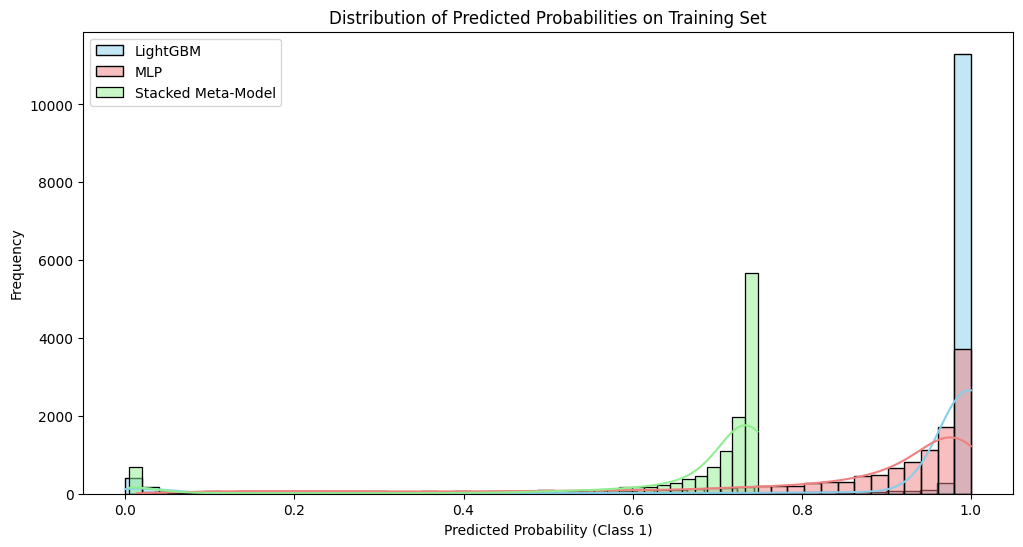

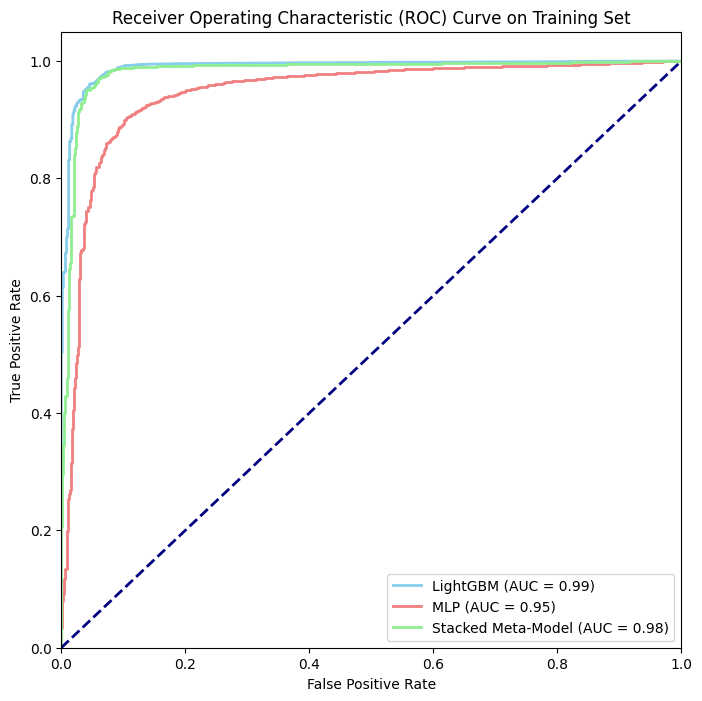

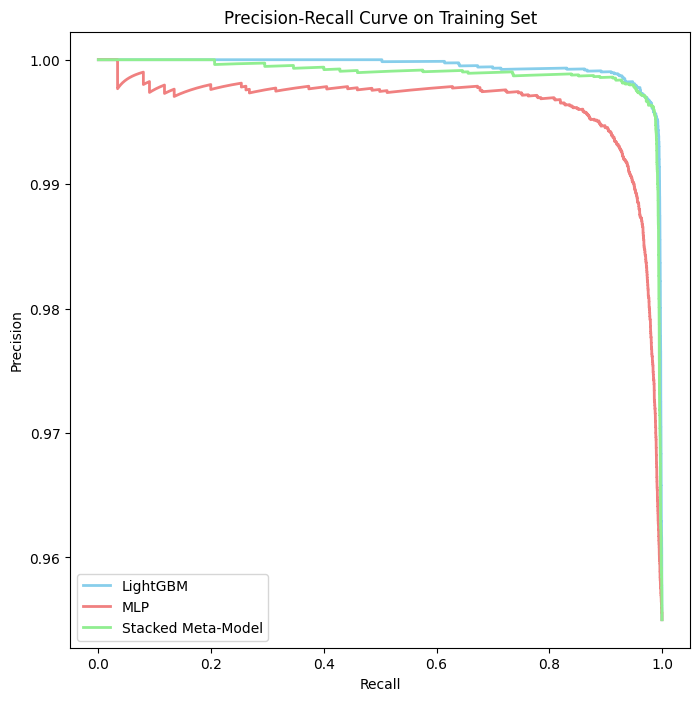

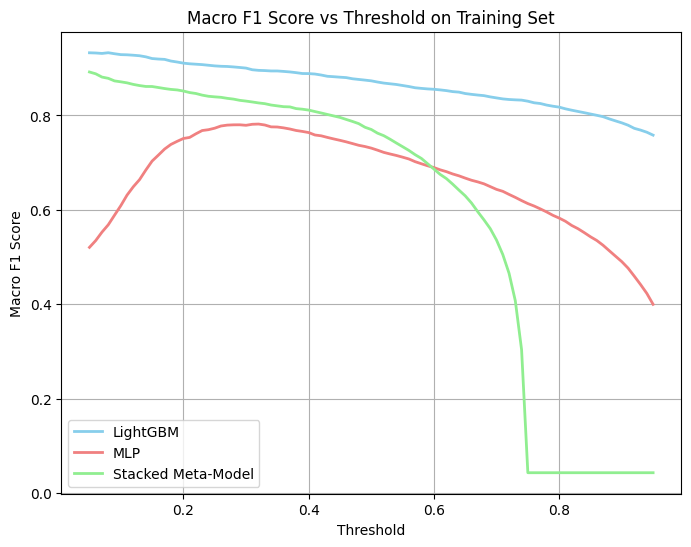

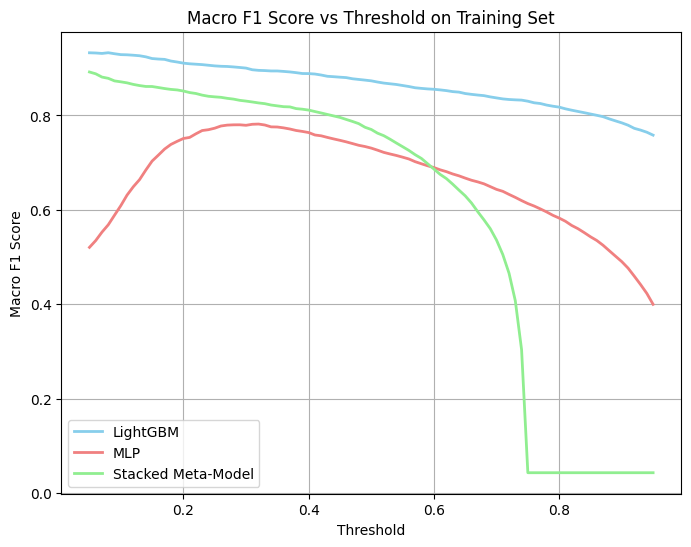

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

# Calculate predictions for the training data
probs_lgb_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
model.eval()
probs_mlp_train = []
with torch.no_grad():
    for i in range(0, X_train.shape[0], BATCH):
        xb = torch.from_numpy(X_train[i:i+BATCH]).float().to(device)
        logits = model(xb)
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        probs_mlp_train.append(p)
probs_mlp_train = np.concatenate(probs_mlp_train)

stack_X_train = np.vstack([probs_lgb_train, probs_mlp_train]).T
meta_probs_train = meta_clf.predict_proba(stack_X_train)[:,1]


# Plotting the distribution of predictions for training data
plt.figure(figsize=(12, 6))
sns.histplot(probs_lgb_train, bins=50, color='skyblue', label='LightGBM', kde=True)
sns.histplot(probs_mlp_train, bins=50, color='lightcoral', label='MLP', kde=True)
sns.histplot(meta_probs_train, bins=50, color='lightgreen', label='Stacked Meta-Model', kde=True)
plt.title('Distribution of Predicted Probabilities on Training Set')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plotting ROC curves for training data
plt.figure(figsize=(8, 8))
fpr_lgb_train, tpr_lgb_train, _ = roc_curve(y_train, probs_lgb_train)
roc_auc_lgb_train = auc(fpr_lgb_train, tpr_lgb_train)
plt.plot(fpr_lgb_train, tpr_lgb_train, color='skyblue', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb_train:.2f})')

fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, probs_mlp_train)
roc_auc_mlp_train = auc(fpr_mlp_train, tpr_mlp_train)
plt.plot(fpr_mlp_train, tpr_mlp_train, color='lightcoral', lw=2, label=f'MLP (AUC = {roc_auc_mlp_train:.2f})')

fpr_meta_train, tpr_meta_train, _ = roc_curve(y_train, meta_probs_train)
roc_auc_meta_train = auc(fpr_meta_train, tpr_meta_train)
plt.plot(fpr_meta_train, tpr_meta_train, color='lightgreen', lw=2, label=f'Stacked Meta-Model (AUC = {roc_auc_meta_train:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Training Set')
plt.legend(loc="lower right")
plt.show()

# Plotting Precision-Recall curves for training data
plt.figure(figsize=(8, 8))
precision_lgb_train, recall_lgb_train, _ = precision_recall_curve(y_train, probs_lgb_train)
plt.plot(recall_lgb_train, precision_lgb_train, color='skyblue', lw=2, label='LightGBM')

precision_mlp_train, recall_mlp_train, _ = precision_recall_curve(y_train, probs_mlp_train)
plt.plot(recall_mlp_train, precision_mlp_train, color='lightcoral', lw=2, label='MLP')

precision_meta_train, recall_meta_train, _ = precision_recall_curve(y_train, meta_probs_train)
plt.plot(recall_meta_train, precision_meta_train, color='lightgreen', lw=2, label='Stacked Meta-Model')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Training Set')
plt.legend(loc="lower left")
plt.show()

# Plotting Micro F1 vs Threshold for training data
thresholds = np.linspace(0.05, 0.95, 91)
f1_micro_lgb_train = [f1_score(y_train, (probs_lgb_train >= t).astype(int), average='macro') for t in thresholds]
f1_micro_mlp_train = [f1_score(y_train, (probs_mlp_train >= t).astype(int), average='macro') for t in thresholds]
f1_micro_meta_train = [f1_score(y_train, (meta_probs_train >= t).astype(int), average='macro') for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_micro_lgb_train, color='skyblue', lw=2, label='LightGBM')
plt.plot(thresholds, f1_micro_mlp_train, color='lightcoral', lw=2, label='MLP')
plt.plot(thresholds, f1_micro_meta_train, color='lightgreen', lw=2, label='Stacked Meta-Model')
plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score vs Threshold on Training Set')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Macro F1 vs Threshold for training data
f1_macro_lgb_train = [f1_score(y_train, (probs_lgb_train >= t).astype(int), average='macro') for t in thresholds]
f1_macro_mlp_train = [f1_score(y_train, (probs_mlp_train >= t).astype(int), average='macro') for t in thresholds]
f1_macro_meta_train = [f1_score(y_train, (meta_probs_train >= t).astype(int), average='macro') for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_macro_lgb_train, color='skyblue', lw=2, label='LightGBM')
plt.plot(thresholds, f1_macro_mlp_train, color='lightcoral', lw=2, label='MLP')
plt.plot(thresholds, f1_macro_meta_train, color='lightgreen', lw=2, label='Stacked Meta-Model')
plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score vs Threshold on Training Set')
plt.legend()
plt.grid(True)
plt.show()

###### Testing

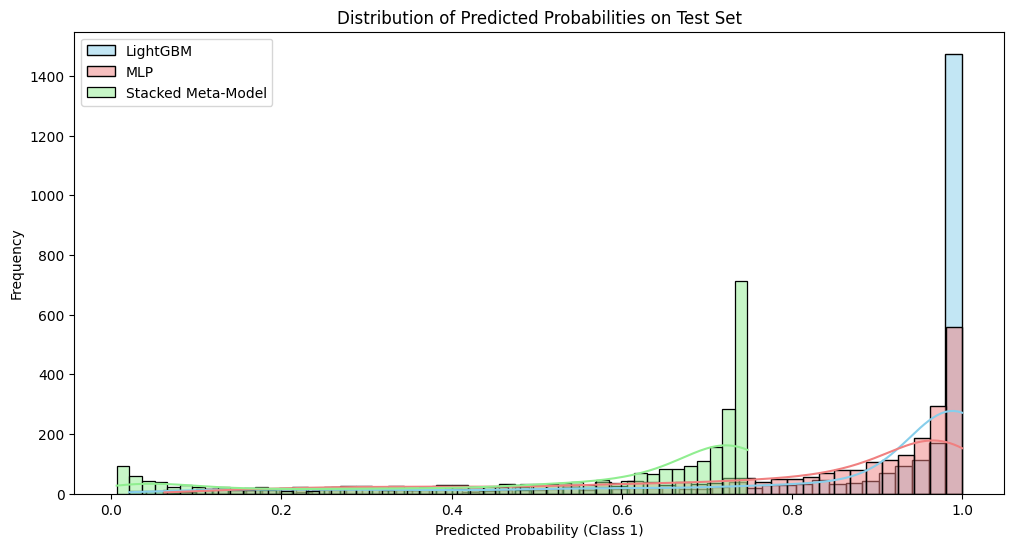

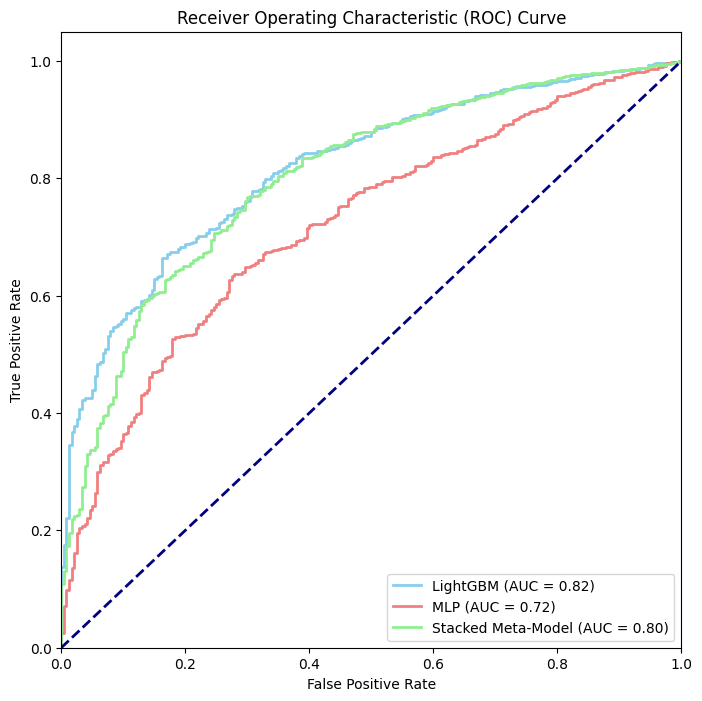

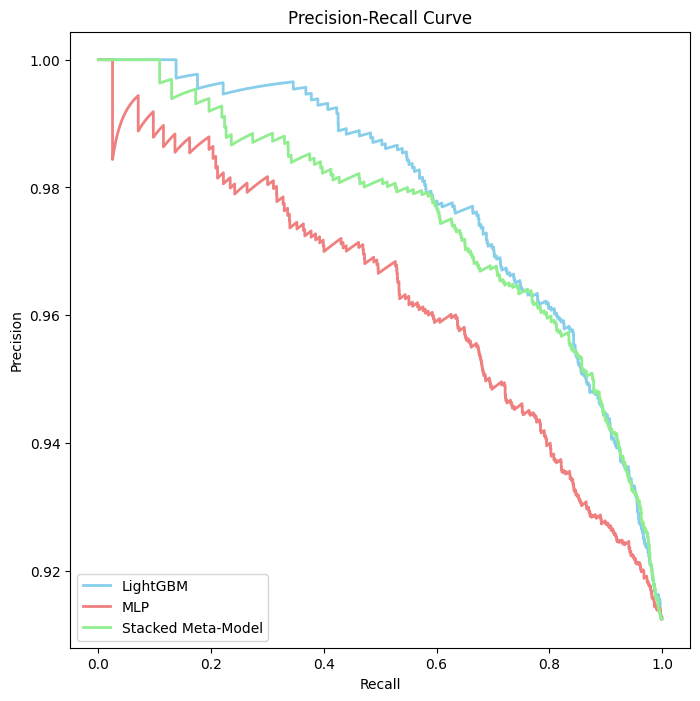

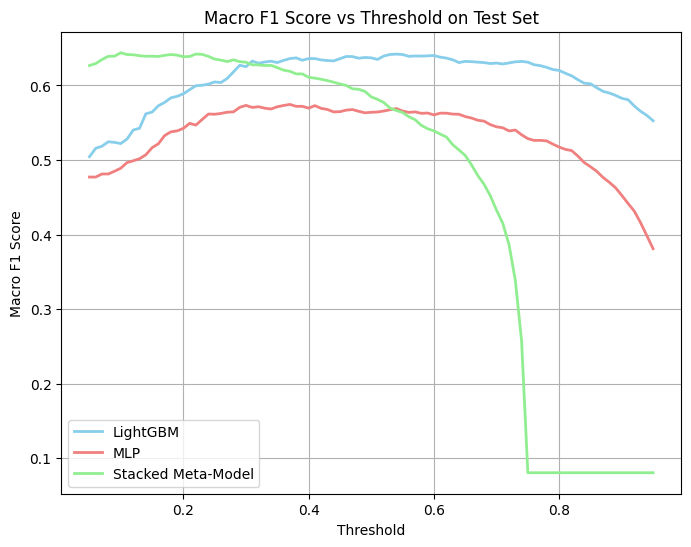

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

# Plotting the distribution of predictions
plt.figure(figsize=(12, 6))
sns.histplot(probs_lgb_test, bins=50, color='skyblue', label='LightGBM', kde=True)
sns.histplot(probs_mlp_test, bins=50, color='lightcoral', label='MLP', kde=True)
sns.histplot(meta_probs_test, bins=50, color='lightgreen', label='Stacked Meta-Model', kde=True)
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plotting ROC curves
plt.figure(figsize=(8, 8))
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, probs_lgb_test)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.plot(fpr_lgb, tpr_lgb, color='skyblue', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp_test)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, color='lightcoral', lw=2, label=f'MLP (AUC = {roc_auc_mlp:.2f})')

fpr_meta, tpr_meta, _ = roc_curve(y_test, meta_probs_test)
roc_auc_meta = auc(fpr_meta, tpr_meta)
plt.plot(fpr_meta, tpr_meta, color='lightgreen', lw=2, label=f'Stacked Meta-Model (AUC = {roc_auc_meta:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting Precision-Recall curves
plt.figure(figsize=(8, 8))
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, probs_lgb_test)
plt.plot(recall_lgb, precision_lgb, color='skyblue', lw=2, label='LightGBM')

precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, probs_mlp_test)
plt.plot(recall_mlp, precision_mlp, color='lightcoral', lw=2, label='MLP')

precision_meta, recall_meta, _ = precision_recall_curve(y_test, meta_probs_test)
plt.plot(recall_meta, precision_meta, color='lightgreen', lw=2, label='Stacked Meta-Model')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Plotting Micro F1 vs Threshold
thresholds = np.linspace(0.05, 0.95, 91)
f1_micro_lgb = [f1_score(y_test, (probs_lgb_test >= t).astype(int), average='macro') for t in thresholds]
f1_micro_mlp = [f1_score(y_test, (probs_mlp_test >= t).astype(int), average='macro') for t in thresholds]
f1_micro_meta = [f1_score(y_test, (meta_probs_test >= t).astype(int), average='macro') for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_micro_lgb, color='skyblue', lw=2, label='LightGBM')
plt.plot(thresholds, f1_micro_mlp, color='lightcoral', lw=2, label='MLP')
plt.plot(thresholds, f1_micro_meta, color='lightgreen', lw=2, label='Stacked Meta-Model')
plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score vs Threshold on Test Set')
plt.legend()
plt.grid(True)
plt.show()